<a href="https://colab.research.google.com/github/hirotakasaito/dl_study/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch #pytorchをインポート
import torch.nn as nn #損失関数や全結合層などの関数やクラスが定義されている
import torch.nn.functional as F
from torchvision import datasets, transforms #学習データの前処理

Epoch: 1/100 
 Generator_loss: 1.3859183231056564 
 Disriminator_loss: 0.9027534737276548
Epoch: 2/100 
 Generator_loss: 2.622523939851254 
 Disriminator_loss: 0.5248771349928295
Epoch: 3/100 
 Generator_loss: 2.9095100720384206 
 Disriminator_loss: 0.4719418390329009
Epoch: 4/100 
 Generator_loss: 2.956184444203575 
 Disriminator_loss: 0.4729351096626534
Epoch: 5/100 
 Generator_loss: 2.954058310265475 
 Disriminator_loss: 0.4941514054891776
Epoch: 6/100 
 Generator_loss: 2.9634992829509073 
 Disriminator_loss: 0.485616384728105
Epoch: 7/100 
 Generator_loss: 3.2751279849252937 
 Disriminator_loss: 0.45695187824131206
Epoch: 8/100 
 Generator_loss: 3.231535725303495 
 Disriminator_loss: 0.47601188081560164
Epoch: 9/100 
 Generator_loss: 3.29581974969984 
 Disriminator_loss: 0.49341777854439034
Epoch: 10/100 
 Generator_loss: 3.0780773183197705 
 Disriminator_loss: 0.5259511127288721
Epoch: 11/100 
 Generator_loss: 2.799651220234125 
 Disriminator_loss: 0.5654567852854856
Epoch: 12/100

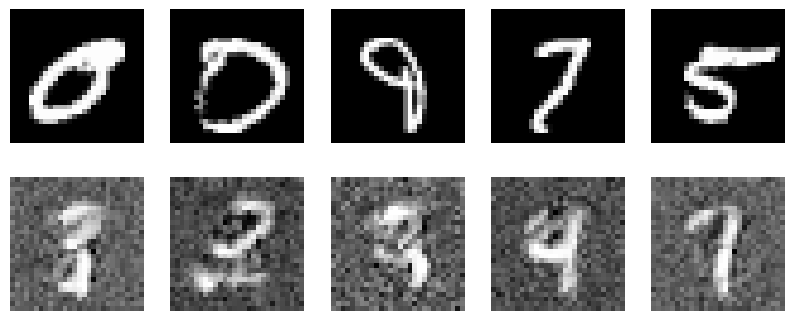

In [30]:
#GANを用いたMNIST生成モデル

%matplotlib inline
import matplotlib.pyplot as plt

#----------------------------------------------------------
# ハイパーパラメータなどの設定値
num_epochs = 100         # 学習を繰り返す回数
num_batch = 64         # 一度に処理する画像の枚数
z_size = 100           #ノイズサイズ
learning_rate = 0.001   # 学習率
image_size = 28*28      # 画像の画素数(幅x高さ)

# GPU(CUDA)が使えるかどうか？
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#----------------------------------------------------------
# 学習用／評価用のデータセットの作成

# 変換方法の指定
transform = transforms.Compose([
    transforms.ToTensor()
    ])

# MNISTデータの取得
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
# 学習用
train_dataset = datasets.MNIST(
    './data',               # データの保存先
    train = True,           # 学習用データを取得する
    download = True,        # データが無い時にダウンロードする
    transform = transform   # テンソルへの変換など
    )
# 評価用
test_dataset = datasets.MNIST(
    './data',
    train = False,
    transform = transform
    )

# データローダー
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = num_batch,
    drop_last=True,
    shuffle = True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = num_batch,
    drop_last=True,
    shuffle = True)

#----------------------------------------------------------
# ニューラルネットワークモデルの定義
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        # 各クラスのインスタンス（入出力サイズなどの設定）
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        # 順伝播の設定（インスタンスしたクラスの特殊メソッド(__call__)を実行）
        x = self.fc1(x)
        x = self.relu(x) #活性化関数
        x = self.fc2(x)
        x = self.relu(x) #活性化関数
        x = self.fc3(x)
        x = torch.sigmoid(x) #0 or 1 (0:fake, 1:true)
        return x

class Generator(nn.Module):
    def __init__(self, z_size, output_size):
        super(Generator, self).__init__()

        # 各クラスのインスタンス（入出力サイズなどの設定）
        self.fc1 = nn.Linear(z_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        # 順伝播の設定（インスタンスしたクラスの特殊メソッド(__call__)を実行）
        x = self.fc1(x)
        x = self.relu(x) #活性化関数
        x = self.fc2(x)
        x = self.relu(x) #活性化関数
        x = self.fc3(x)
        x = self.tanh(x)
        return x

#----------------------------------------------------------
# ニューラルネットワークの生成
generator_model = Generator(z_size, image_size).to(device)
discriminator_model = Discriminator(image_size).to(device)

#----------------------------------------------------------
# 損失関数の設定
criterion = nn.BCELoss()
#----------------------------------------------------------
# 最適化手法の設定

one_labels = torch.ones(num_batch).to(device)
zero_labels = torch.zeros(num_batch).to(device)

optimizer_netD = torch.optim.Adam(discriminator_model.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizer_netG = torch.optim.Adam(generator_model.parameters(), lr=0.0002, betas=[0.5, 0.999])
#----------------------------------------------------------
# 学習
generator_model.train()  # モデルを訓練モードにする
discriminator_model.train()  # モデルを訓練モードにする

for epoch in range(num_epochs): # 学習を繰り返し行う
    sum_discriminator_loss = 0
    sum_generator_loss = 0

    for inputs, _ in train_dataloader:

        inputs = inputs.to(device)

        #discriminator
        #本物を本物であると識別する処理
        optimizer_netD.zero_grad()
        inputs = inputs.view(-1, image_size) # 画像データ部分を一次元へ並び変える
        output_real_imgs = discriminator_model(inputs).squeeze()
        loss_real_imgs = criterion(output_real_imgs, one_labels)
        loss_real_imgs.backward()

        #偽物を偽物であると識別する処理
        z = torch.randn(num_batch, z_size).to(device)
        fake_imgs = generator_model(z) #偽物画像生成
        output_fake_imgs = discriminator_model(fake_imgs.detach()).squeeze()
        loss_fake_imgs = criterion(output_fake_imgs, zero_labels)
        loss_fake_imgs.backward()

        loss_discriminator = loss_real_imgs + loss_fake_imgs
        optimizer_netD.step()
        sum_discriminator_loss += loss_discriminator

        #generator
        optimizer_netG.zero_grad()
        z = torch.randn(num_batch, z_size).to(device)
        fake_imgs = generator_model(z)
        output_fake_imgs = discriminator_model(fake_imgs).squeeze()
        loss_generator = criterion(output_fake_imgs, one_labels)
        loss_generator.backward()
        optimizer_netG.step()
        sum_generator_loss += loss_generator

    # 学習状況の表示
    print(f"Epoch: {epoch+1}/{num_epochs} \n Generator_loss: {sum_generator_loss.item() / len(train_dataloader)} \n Disriminator_loss: {sum_discriminator_loss.item() / len(train_dataloader)}")

#----------------------------------------------------------
# 評価
generator_model.eval()  # モデルを評価モード
discriminator_model.eval()  # モデルを評価モード
loss_sum = 0
correct = 0
show_labels = [0,1,2,3,4,5,6,7,8,9]
show_img_list = []

sum_discriminator_loss = 0
sum_generator_loss = 0
count = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:

        inputs = inputs.to(device)
        #discriminator
        #本物を本物であると識別する処理
        inputs = inputs.view(-1, image_size) # 画像データ部分を一次元へ並び変える
        output_real_imgs = discriminator_model(inputs).squeeze()
        loss_real_imgs = criterion(output_real_imgs, one_labels)

        #偽物を偽物であると識別する処理
        z = torch.randn(num_batch, z_size).to(device)
        fake_imgs = generator_model(z) #偽物画像生成
        output_fake_imgs = discriminator_model(fake_imgs.detach()).squeeze()
        loss_fake_imgs = criterion(output_fake_imgs, zero_labels)

        loss_discriminator = loss_real_imgs + loss_fake_imgs
        sum_discriminator_loss += loss_discriminator

        #generator
        z = torch.randn(num_batch, z_size).to(device)
        fake_imgs = generator_model(z)
        output_fake_imgs = discriminator_model(fake_imgs).squeeze()
        loss_generator = criterion(output_fake_imgs, one_labels)
        sum_generator_loss += loss_generator

        fake_imgs = fake_imgs.reshape(num_batch, 28, 28)
        inputs = inputs.reshape(num_batch, 28, 28)
        for fake_img, real_img in zip(fake_imgs, inputs):
            if count < 5:
                fake_img = fake_img.squeeze().to('cpu').detach().numpy().copy()
                real_img = real_img.squeeze().to('cpu').detach().numpy().copy()
                show_img_list.append((fake_img, real_img))
            count += 1

    print(f"Eval \n Generator_loss: {sum_generator_loss.item() / len(test_dataloader)} \n Disriminator_loss: {sum_discriminator_loss.item() / len(test_dataloader)}")

print("======================= Visualize image =======================")
fig = plt.figure(figsize=(10,8))
for idx, v in enumerate(show_img_list):
    ax_real = fig.add_subplot(1, 5, idx+1)
    ax_fake = fig.add_subplot(2, 5, idx+1)
    ax_real.imshow(v[0],cmap="gray")
    ax_fake.imshow(v[1],cmap="gray")
    ax_real.axis("off")
    ax_fake.axis("off")
plt.show()